<p style="background-color:#673AB7;color:white;font-size:22px;text-align:center;border-radius:10px 10px;font-weight:bold;border:2px solid #673AB7;">Insurance cost forecasting</p>

<span style="background-color:#673AB7;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #673AB7;padding:0px 20px">Table of Contents</span>
1. [Introduction](#1)
2. [Case study](#2)
3. [Explore Data with the plot method](#3)
4. [Split the data into training and testing](#4)
5. [Implementation with StatsForecast](#5)
6. [Evaluate the model](#6)
7. [Exogenous variables](#7)
8. [Splitting training and test data with exogenous variables](#8)
9. [Implementation of StatsForecast with exogenous variables](#9)
10. [Evaluate the model for exogenous variables](#10)
11. [Conclusion](#11)
12. [References](12)

<a id="1"></a> 

<span style="background-color:#673AB7;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #673AB7;padding:0px 20px">Introduction</span>

<a id="2"></a>

<span style="background-color:#673AB7;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #673AB7;padding:0px 20px">Case study</span>

<span style="background-color:#673AB7;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #673AB7;padding:0px 20px">Importing Libraries</span>

In [1]:
# Handling and processing of Data
# ==============================================================================
import numpy as np
import pandas as pd

# StatsForecast
# ==============================================================================
from statsforecast import StatsForecast
from utilsforecast.plotting import plot_series

from statsmodels.tsa.stattools import adfuller

# Time
# ==============================================================================
from datetime import datetime, date
from datetime import timedelta
import datetime as dt # working with time data

# Hide warnings
# ==============================================================================
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")

/Users/user/Documents/miniconda3/envs/statsforecast/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# Plot
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from IPython.core.display import HTML,display
import seaborn as sns
plt.style.use('grayscale') # fivethirtyeight  grayscale  classic
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#99FFDE',  # #212946  '#99FFDE', '#ffde99', '#de99ff' # #212946  '#99FFDE', '#ffde99', '#de99ff'  'coral','#FFDAB9','yellowgreen','#6495ED'
    'axes.facecolor': '#99FFDE',
    'savefig.facecolor': '#99FFDE',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': 'black',  #2A3459
    'grid.linewidth': '1',
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'font.size': 12 }
plt.rcParams.update(dark_style)
# Define the plot size
# ==============================================================================

plt.rcParams['figure.figsize'] = (18,7)

# Hide warnings
# ==============================================================================
import warnings
warnings.filterwarnings("ignore")

<span style="background-color:#673AB7;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #673AB7;padding:0px 20px">Importing Data</span>

This dataset has 8 variable:

* Age: age of primary beneficiary.

* Sex: insurance contractor gender, female, male.

* BMI: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg/m^2) using the ratio of height to weight, ideally 18.5 to 24.9.

* Children: Number of children covered by health insurance/Number of dependents.

* Smoker: Is the person a smoker or not.

* Region: the beneficiary’s residential area in the US, northeast, southeast, southwest, northwest.

* Charges: Individual medical costs billed by health insurance.

* ds:date of the policy generated

In [3]:
df=pd.read_csv("../tutorial/insurance.csv",usecols=lambda column: column != 'Unnamed: 0', parse_dates=["ds"])
df.head()

,age,sex,bmi,children,smoker,region,charges,ds
0,19,female,27.900,0,yes,southwest,16884.92400,2017-01-02
1,18,male,33.770,1,no,southeast,1725.55230,2017-01-03
2,28,male,33.000,3,no,southeast,4449.46200,2017-01-04
3,33,male,22.705,0,no,northwest,21984.47061,2017-01-05
4,32,male,28.880,0,no,northwest,3866.85520,2017-01-06


The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [4]:
df["unique_id"]="1"
df=df.rename(columns={"charges": "y"})
df.head()

,age,sex,bmi,children,smoker,region,y,ds,unique_id
0,19,female,27.900,0,yes,southwest,16884.92400,2017-01-02,1
1,18,male,33.770,1,no,southeast,1725.55230,2017-01-03,1
2,28,male,33.000,3,no,southeast,4449.46200,2017-01-04,1
3,33,male,22.705,0,no,northwest,21984.47061,2017-01-05,1
4,32,male,28.880,0,no,northwest,3866.85520,2017-01-06,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   age        1338 non-null   int64         
 1   sex        1338 non-null   object        
 2   bmi        1338 non-null   float64       
 3   children   1338 non-null   int64         
 4   smoker     1338 non-null   object        
 5   region     1338 non-null   object        
 6   y          1338 non-null   float64       
 7   ds         1338 non-null   datetime64[ns]
 8   unique_id  1338 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 94.2+ KB


<a id="3"></a>

<span style="background-color:#673AB7;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #673AB7;padding:0px 20px">Explore Data with the plot method</span>

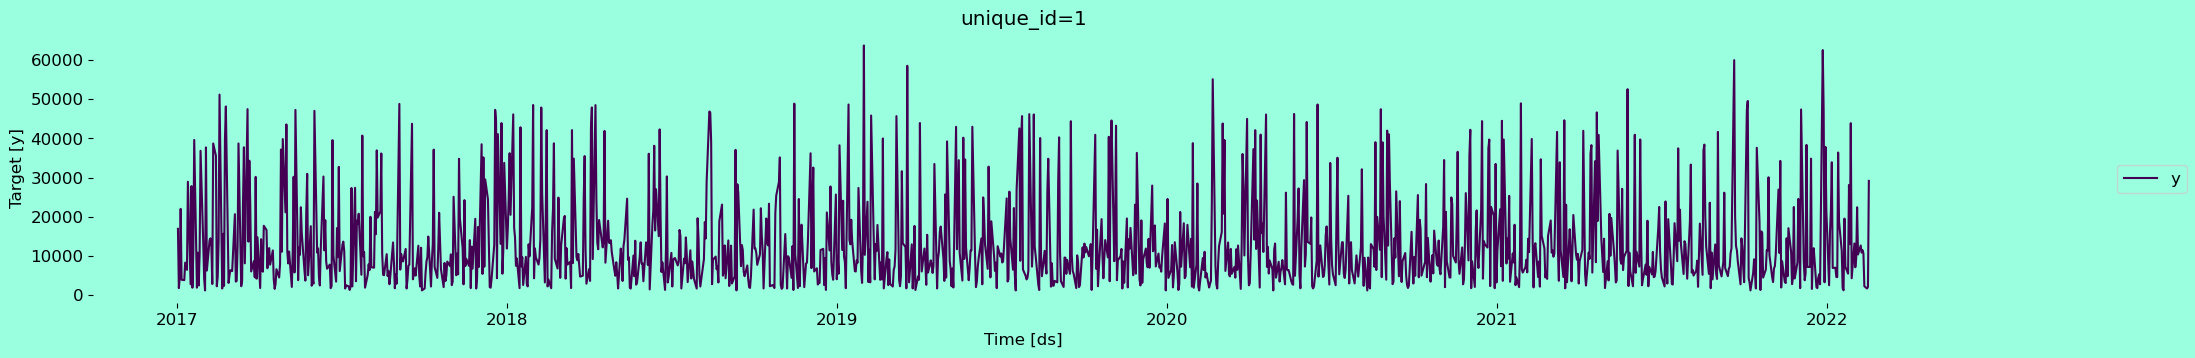

In [6]:
plot_series(df)

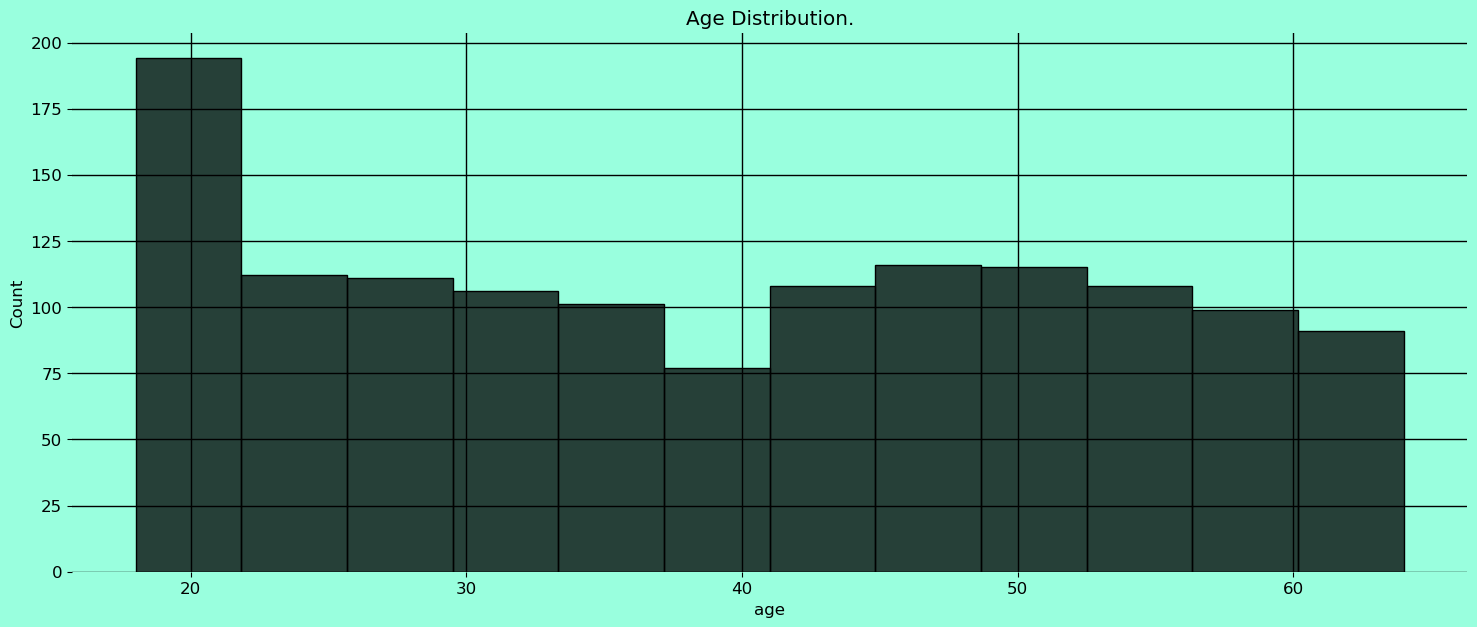

In [7]:
sns.histplot(df, x="age")
plt.title("Age Distribution.")
plt.show()

From the chart above :

* the high density of people in range 18 to 23

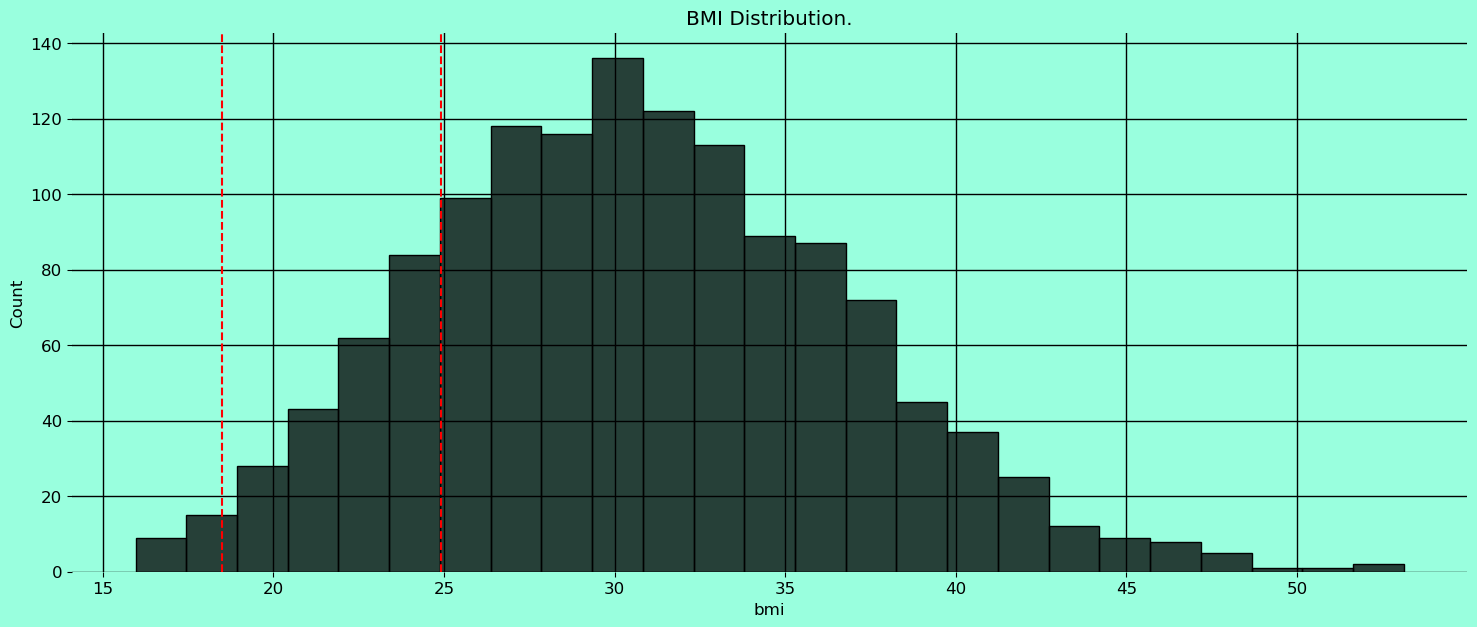

In [8]:
sns.histplot(data=df, x="bmi")
plt.title("BMI Distribution.")
plt.axvline(18.5, color="red", linestyle='--')
plt.axvline(24.9, color="red", linestyle='--')
plt.show()

From the chart above :

* BMI : the distribution is normal distribution
* from the describtion of data, the BMI range is 18.5 to 24.9.
* There are a large number of people who are overweight

In [9]:
## (len(data[(data['bmi'] > 18.5) & (data['bmi'] < 24.9)]) / 1338) * 100
normal = ((df['bmi'] > 18.5) & (df['bmi'] < 24.9)).mean()

## (len(data[data['bmi'] > 24.9]) / 1338) * 100
over =  (df['bmi'] > 24.9).mean()

print(f"Normal weight: {round(normal,2)*100}%\nOverweight: {round(over,2)*100}%")

Normal weight: 17.0%
Overweight: 82.0%


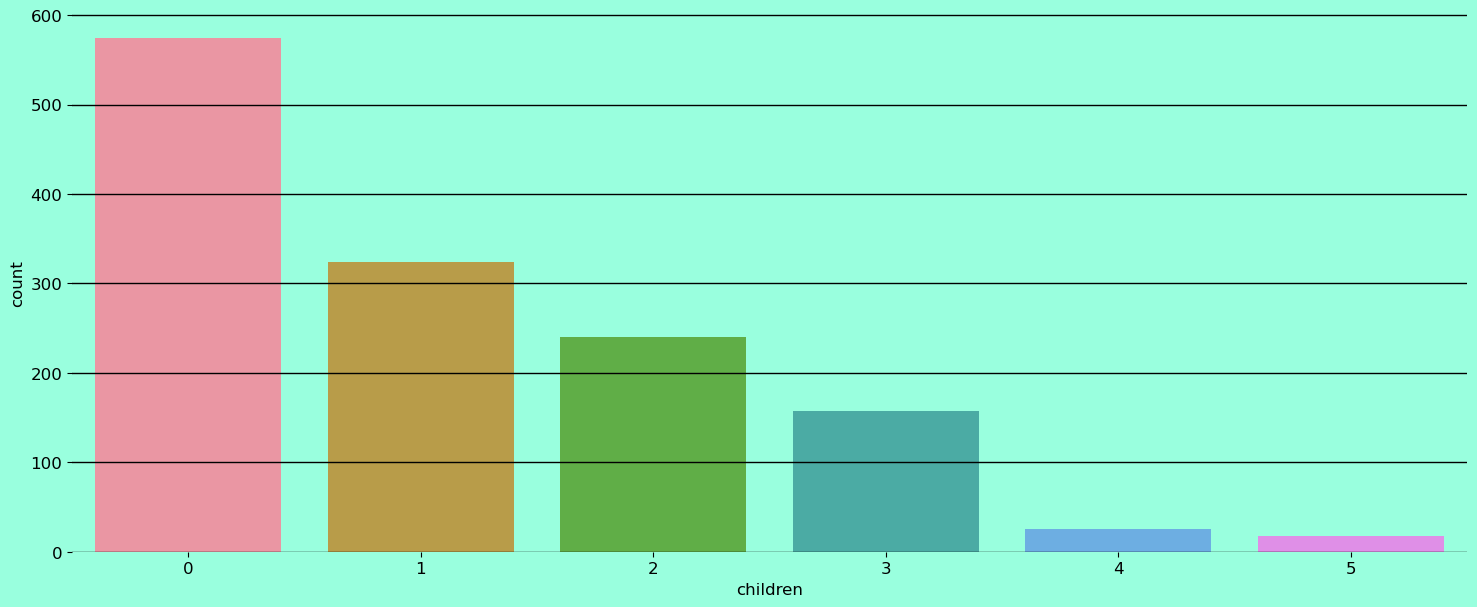

In [10]:
sns.countplot(data=df, x="children")
plt.show()

From the chart above :

* Most people in the data do not have children

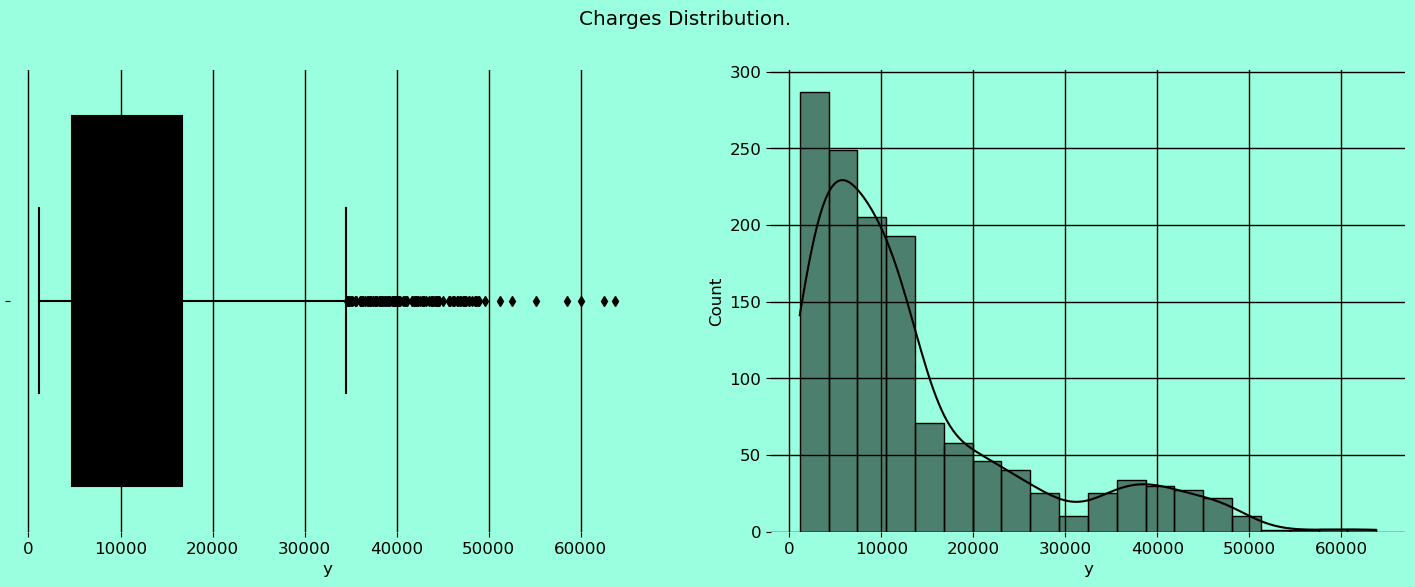

In [11]:
fig, axis = plt.subplots(1, 2, figsize=(18,6))
sns.boxplot(df, x="y", ax=axis[0])

sns.histplot(df, x="y", ax=axis[1],bins = 20, kde = True)
fig.suptitle("charges Distribution.".title())
plt.show()

From the chart above :

* There are outliers in the charges column
* Right skewed distribution
* Most people's charges range from 1122 to 16600

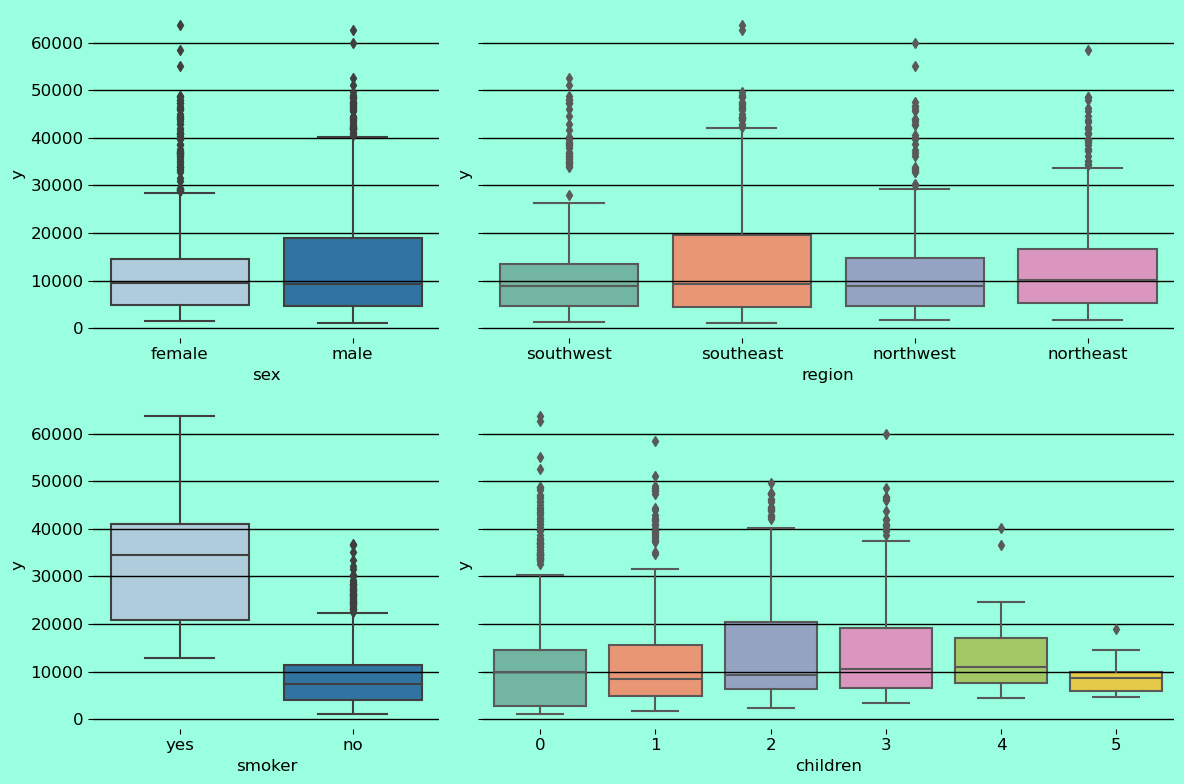

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), width_ratios=[1, 2], layout='tight', sharey=True)
sns.boxplot(data=df, x='sex', y='y', palette='Paired', ax=axs[0, 0])
sns.boxplot(data=df, x='region', y='y', palette='Set2', ax=axs[0, 1])
sns.boxplot(data=df, x='smoker', y='y', palette='Paired', ax=axs[1, 0])
sns.boxplot(data=df, x='children', y='y', palette='Set2', ax=axs[1, 1])
plt.show()

* With the naked eye, smoker has a large and significant impact on charges.

* Others possibly contribute to expenses but their significance and magnitude needs more work.

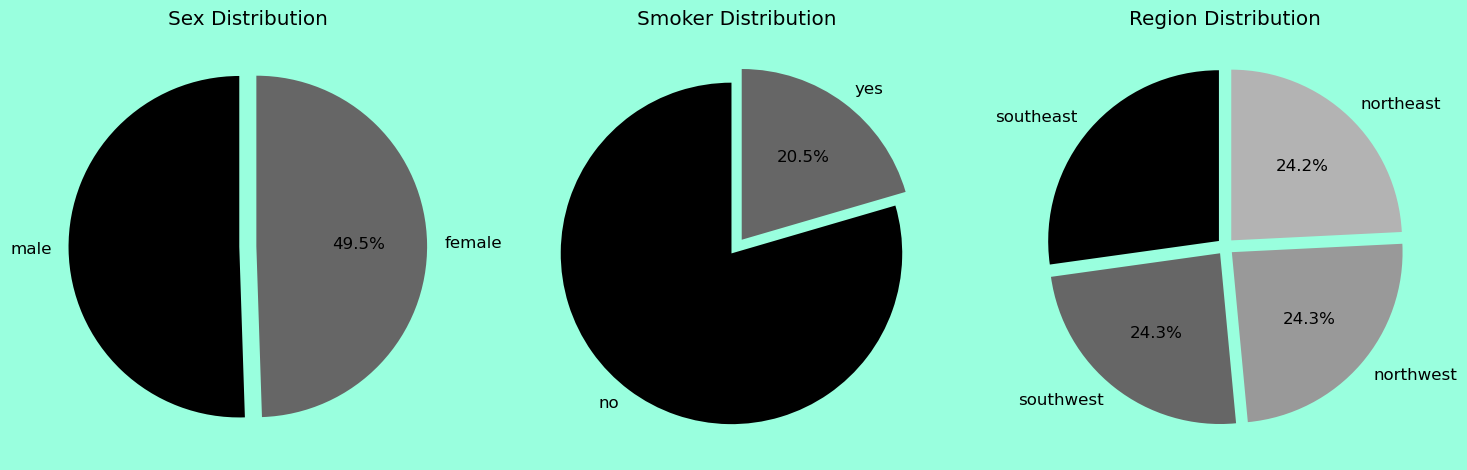

In [13]:
# Set up the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Set style
# sns.set(style="darkgrid")

# Define explode values for 3D effect
explode_sex = (0.05, 0.05)  # Two slices in the 'sex' pie chart
explode_smoker = (0.05, 0.05)  # Two slices in the 'smoker' pie chart
explode_region = (0.05, 0.05, 0.05, 0.05)  # Four slices in the 'region' pie chart

# Pie chart for 'sex'
sns.set_palette("pastel")
sex_counts = df['sex'].value_counts()
axes[0].pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=90, explode=explode_sex)
axes[0].set_title("Sex Distribution")

# Pie chart for 'smoker'
sns.set_palette("muted")
smoker_counts = df['smoker'].value_counts()
axes[1].pie(smoker_counts, labels=smoker_counts.index, autopct='%1.1f%%', startangle=90, explode=explode_smoker)
axes[1].set_title("Smoker Distribution")

# Pie chart for 'region'
sns.set_palette("dark")
region_counts = df['region'].value_counts()
axes[2].pie(region_counts, labels=region_counts.index, autopct='%1.1f%%', startangle=90, explode=explode_region)
axes[2].set_title("Region Distribution")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


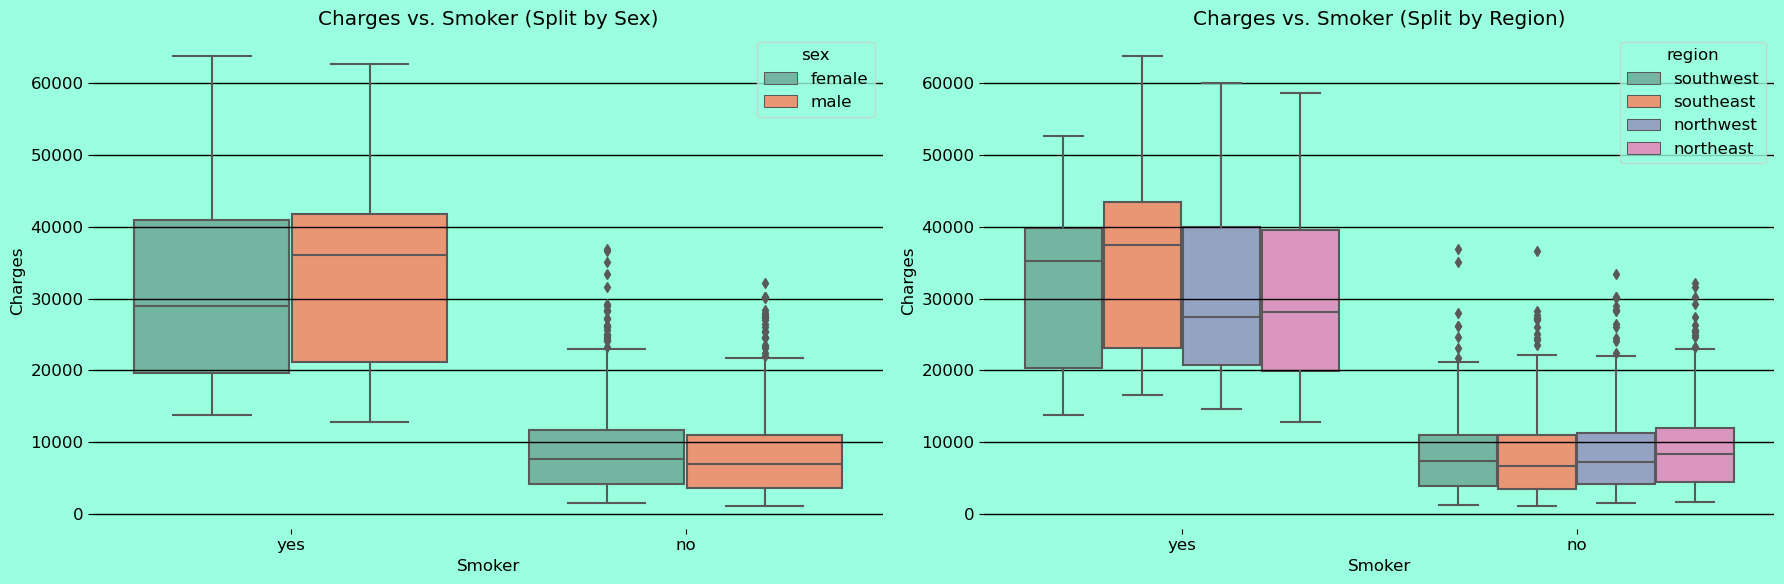

In [14]:
# Create a boxplot grid for charges vs. smoker, with 'sex' and 'region' as additional dimensions
plt.figure(figsize=(18, 6))
sns.boxplot(x='smoker', y='y', hue='sex', data=df, palette='Set2', ax=plt.subplot(121))
plt.title('Charges vs. Smoker (Split by Sex)')
plt.xlabel('Smoker')
plt.ylabel('Charges')

sns.boxplot(x='smoker', y='y', hue='region', data=df, palette='Set2', ax=plt.subplot(122))
plt.title('Charges vs. Smoker (Split by Region)')
plt.xlabel('Smoker')
plt.ylabel('Charges')

plt.tight_layout()
plt.show()

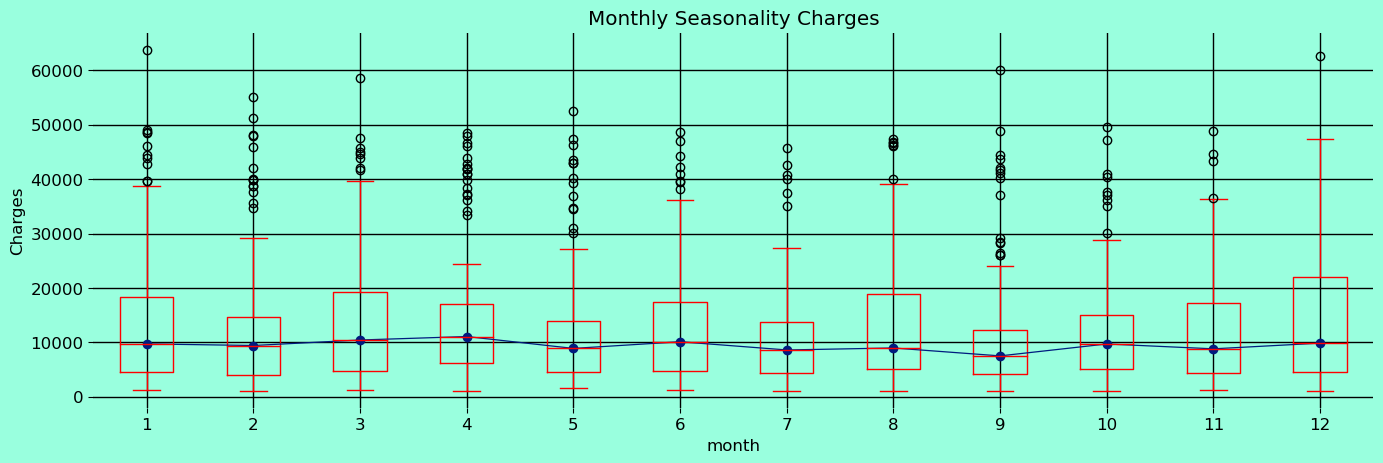

In [15]:
df1=df.copy()
# Boxplot graph for monthly seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(16, 5))
df1['month'] = df1['ds'].apply(lambda x: x.month)
df1.boxplot(column="y", by='month', ax=ax, color="red")
df1.groupby('month')["y"].median().plot(style='o-', linewidth=0.9, ax=ax)
ax.set_ylabel('Charges')
ax.set_title('Monthly Seasonality Charges')
fig.suptitle('');
#plt.savefig("Gráfico de Barra-mes")

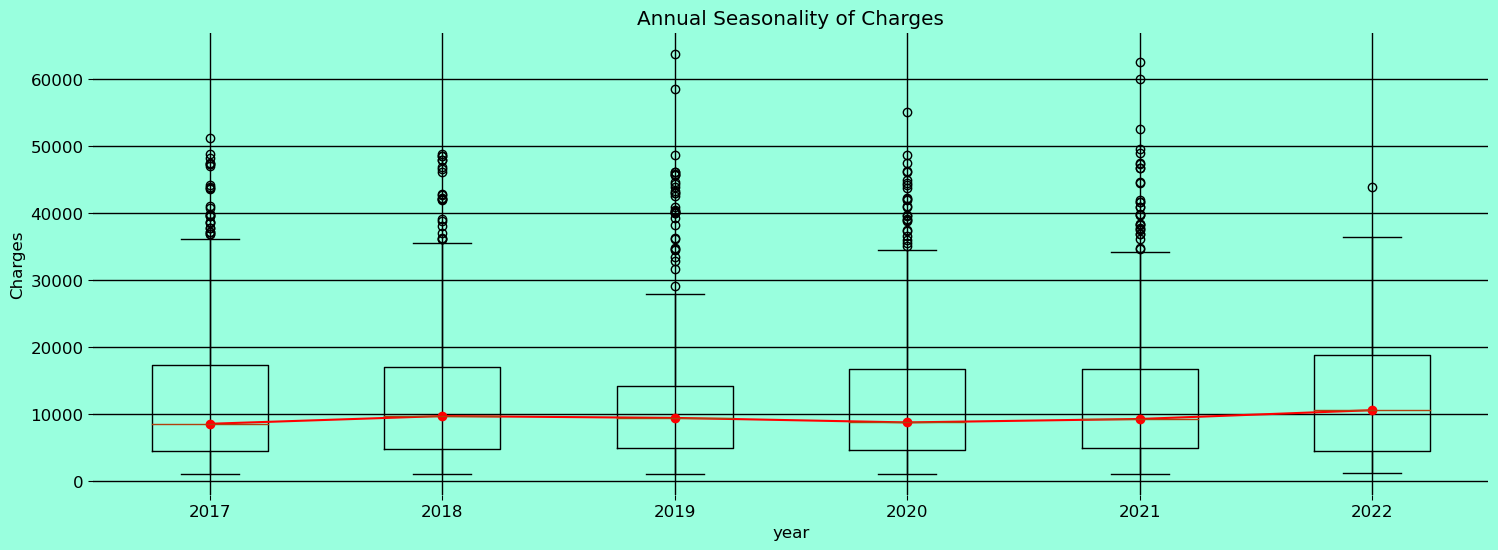

In [16]:
# Boxplot graph for annual seasonality
# ==============================================================================
# Extract year component from date
df1['year'] = df['ds'].dt.year

# Create a dictionary to store the data for each year
data_anual = {}
for year in df1['year'].unique():
    data_anual[year] = df1.loc[df1['year'] == year, 'y'].values

# Create a data list for the Boxplot chart
boxplot_data = [data_anual[year] for year in sorted(data_anual.keys())]

# Create the Boxplot chart
plt.figure(figsize=(18, 6))
plt.boxplot(boxplot_data, labels=sorted(data_anual.keys()))
plt.xlabel('year')
plt.ylabel('Charges')
plt.title('Annual Seasonality of Charges')

# Add the median line graph
medians = [np.median(data_anual[year]) for year in sorted(data_anual.keys())]
plt.plot(range(1, len(medians) + 1), medians, marker='o', color='red', linestyle='-')

plt.show()

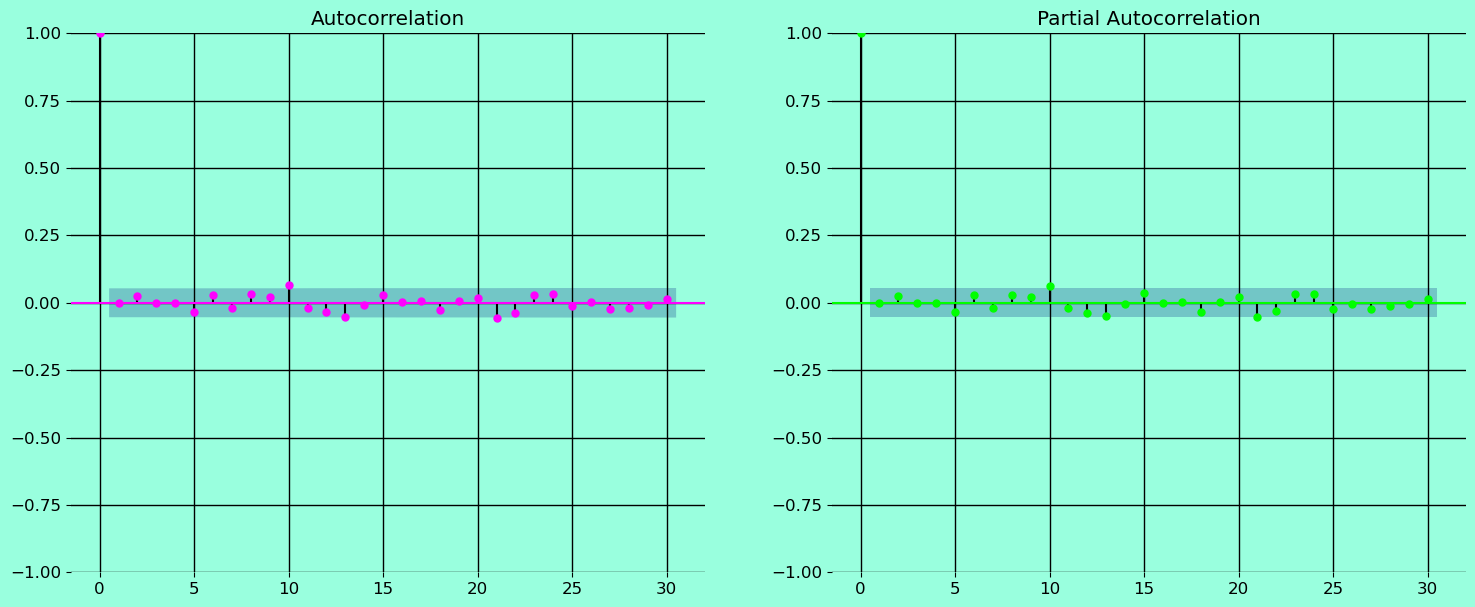

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=30, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df["y"],  lags=30, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

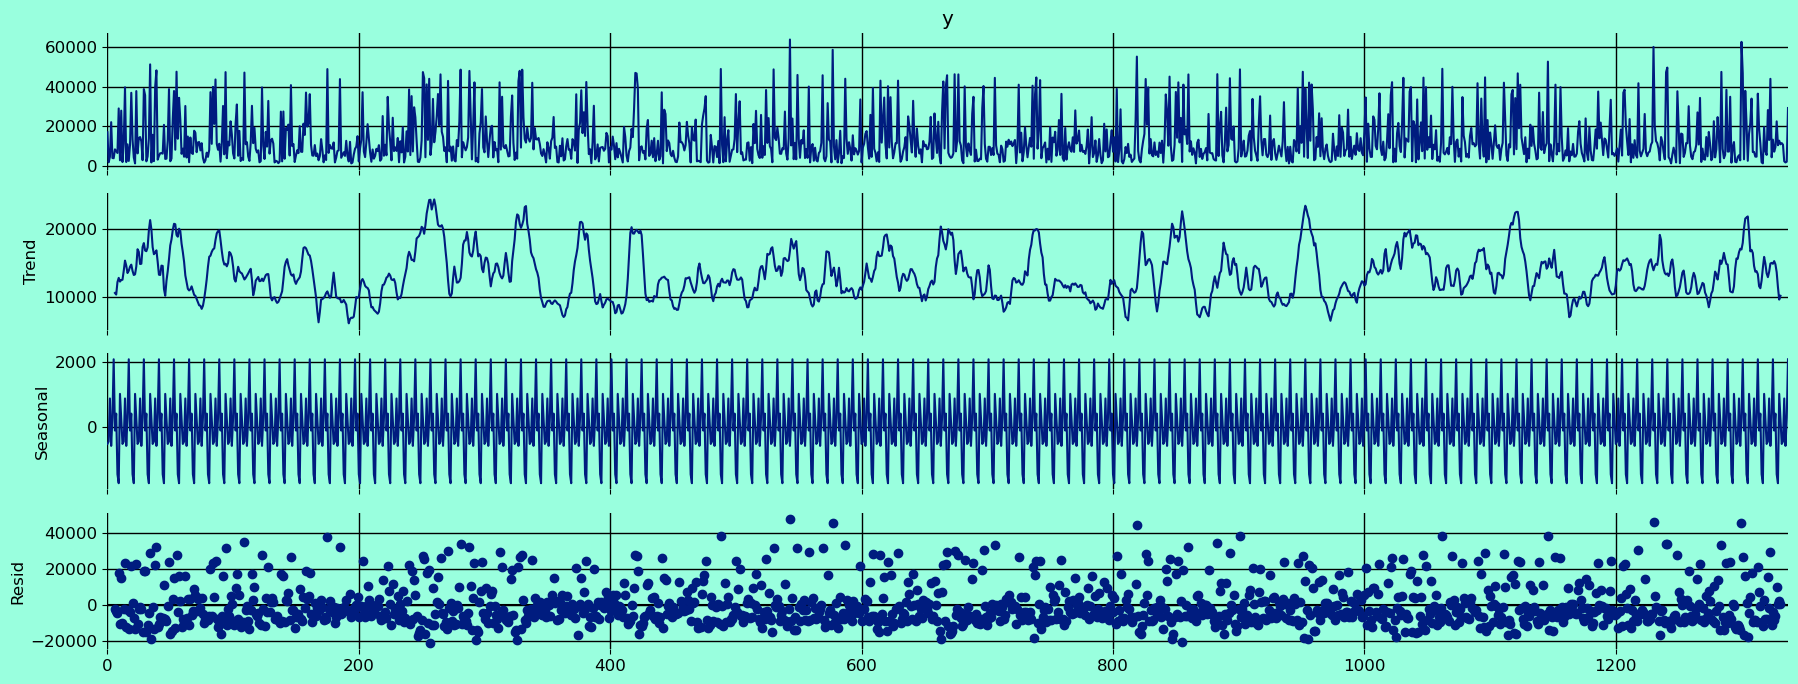

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose 
a = seasonal_decompose(df["y"], model = "additive", period=12)
a.plot();

<a id="4"></a>

<span style="background-color:#673AB7;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #673AB7;padding:0px 20px">Split the data into training and testing</span>

Let's divide our data into two parts:

1. Data to train the model.
2. Data to test the model, here we will use the last 30 daily.

In [ ]:
df.tail()

In [19]:
data=df[["ds","y","unique_id"]]
train = data[data.ds<='2021-05-12'] 
test=data[(data['ds'] > '2021-05-12')]

train.shape, test.shape

((1138, 3), (200, 3))

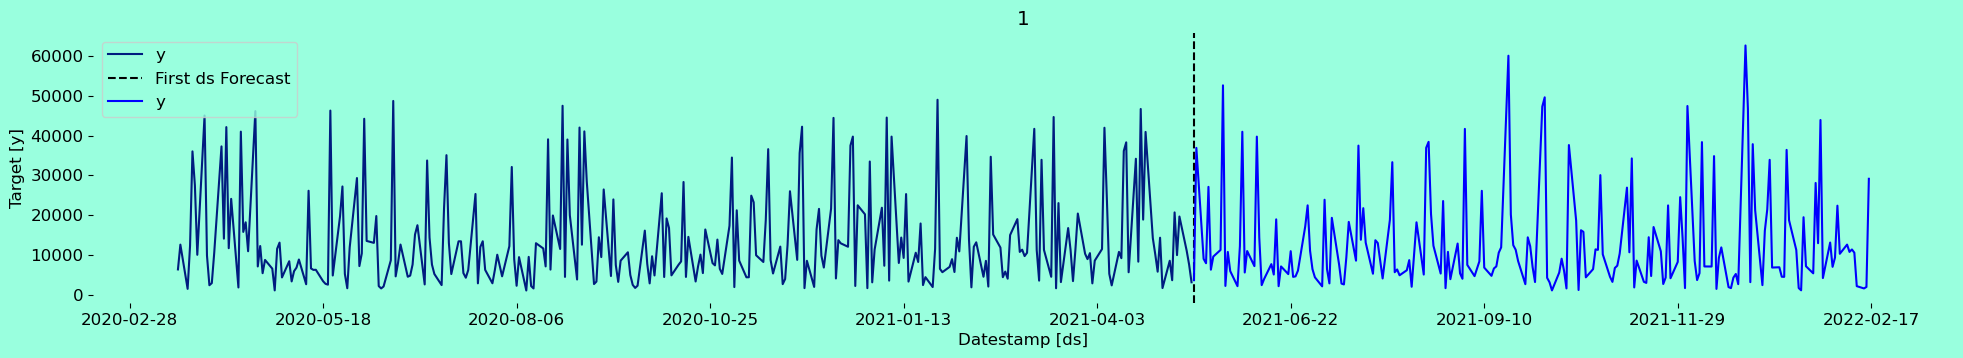

In [20]:
StatsForecast.plot(train, test, max_insample_length=300)

<a id="5"></a>

<span style="background-color:#673AB7;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #673AB7;padding:0px 20px">Implementation with StatsForecast</span>


We are going to train the `AutoARIMA, MSTL` model, using the `AutoARIMA, MSTL` function. This model will help us forecast user demand in the next 200 daily.

In [21]:
from statsforecast import StatsForecast
from statsforecast.models import  AutoARIMA,  SeasonalNaive,  MSTL, AutoETS,AutoCES, AutoTheta, SeasonalExponentialSmoothingOptimized,Holt, HoltWinters

In [22]:
season_length = 7 # monthly data 
horizon = len(test) # number of predictions

# We call the model that we are going to use
models = [AutoARIMA(season_length=season_length),
          AutoETS(season_length=season_length),
          AutoCES(season_length=season_length),
          AutoTheta(season_length=season_length),
          SeasonalNaive(season_length=season_length),
          SeasonalExponentialSmoothingOptimized(season_length=season_length),
          HoltWinters(season_length=season_length, error_type='A', alias='Hws_add'),
          HoltWinters(season_length=season_length, error_type='M', alias='Hws_mul'),
          Holt(season_length=season_length, error_type="A", alias="Holt_Add"),
          Holt(season_length=season_length, error_type="M", alias="Holt_Multi"),
          MSTL(
              season_length=[7, 365], # seasonalities of the time series 
              trend_forecaster=AutoARIMA() )# model used to forecast trend
          ]

In [23]:
# Instantiate StatsForecast class as sf
sf = StatsForecast(
    df=train,
    models=models,
    freq='B', 
    n_jobs=-1)

<span style="background-color:#673AB7;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #673AB7;padding:0px 20px">Fit the Model</span>

In [24]:
sf.fit()

StatsForecast(models=[AutoARIMA,AutoETS,CES,AutoTheta,SeasonalNaive,SeasESOpt,Hws_add,Hws_mul,Holt_Add,Holt_Multi,MSTL])

<span style="background-color:#673AB7;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #673AB7;padding:0px 20px">Predict Method</span>

In [25]:
Y_hat = sf.predict(horizon)

Y_hat

,ds,AutoARIMA,AutoETS,CES,AutoTheta,SeasonalNaive,SeasESOpt,Hws_add,Hws_mul,Holt_Add,Holt_Multi,MSTL
unique_id,,,,,,,,,,,,
1,2021-05-13,9433.077148,14064.818359,13968.573242,12967.566406,3693.427979,17168.607422,13867.887695,14259.658203,13498.296875,13498.079102,19314.730469
1,2021-05-14,5537.074219,13568.818359,13679.060547,12967.556641,20709.019531,16749.425781,13778.864258,13616.456055,13504.944336,13504.727539,20998.486328
1,2021-05-17,4640.789062,14369.224609,14698.399414,12967.546875,9991.038086,14804.854492,14722.165039,14507.391602,13511.458984,13511.242188,1889.067627
1,2021-05-18,3955.425781,14204.910156,14821.425781,12967.537109,19673.335938,15228.860352,14521.874023,14305.876953,13517.843750,13517.626953,14098.145508
1,2021-05-19,4809.618164,11793.552734,11884.065430,12967.527344,11085.586914,12250.190430,11972.244141,12111.302734,13524.099609,13523.883789,3729.658936
...,...,...,...,...,...,...,...,...,...,...,...,...
1,2022-02-10,0.001999,12209.946289,12369.719727,12965.662109,3176.287598,9566.073242,12071.611328,12131.354492,13824.183594,13823.944336,830.842651
1,2022-02-11,0.001852,14064.818359,14011.853516,12965.652344,3693.427979,17168.607422,13862.094727,14254.621094,13824.313477,13824.074219,21055.246094
1,2022-02-14,0.001716,13568.818359,13725.524414,12965.642578,20709.019531,16749.425781,13773.846680,13612.105469,13824.440430,13824.200195,18189.082031


<span style="background-color:#673AB7;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #673AB7;padding:0px 20px">Forecasting Plot</span>

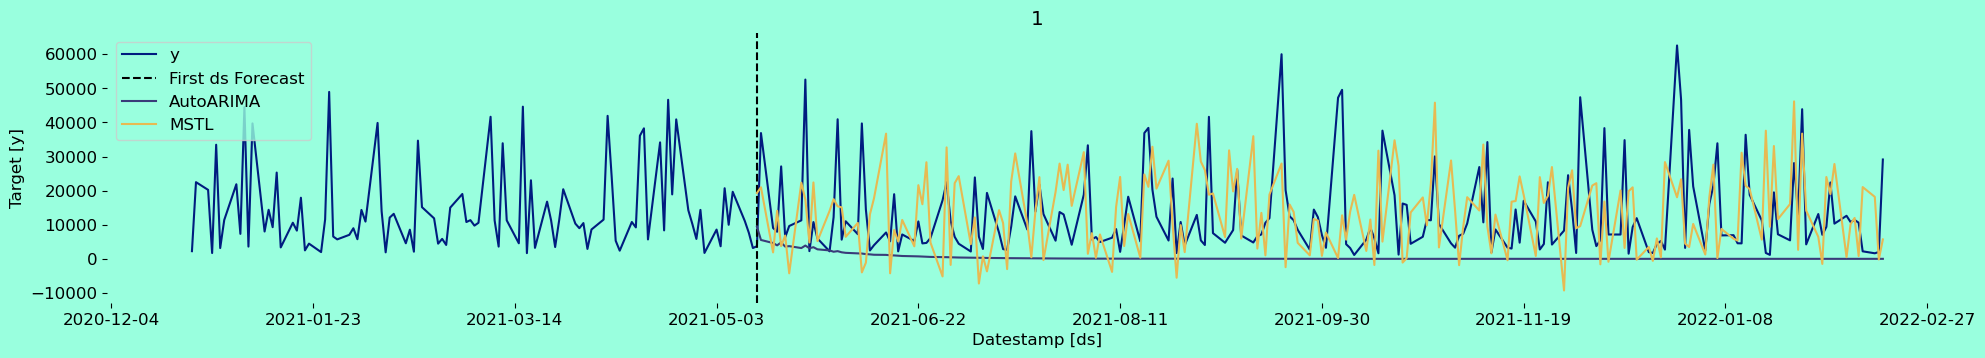

In [26]:
StatsForecast.plot(data, Y_hat, max_insample_length=300, models=["AutoARIMA", "MSTL"])

<a id="6"></a>

<span style="background-color:#673AB7;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #673AB7;padding:0px 20px">Evaluate the model</span>

In [27]:
from datasetsforecast.losses import (mae, mape, mase, rmse, smape)
from utilsforecast.evaluation import evaluate

In [28]:
def evaluate_performace(y_hist, y_true, y_pred, models):
    y_true = pd.merge(y_true,y_pred, how='left', on=['ds'])
    evaluation = {}
    for model in models:
        evaluation[model] = {}
        for metric in [mase, mae, mape, rmse, smape]:
            metric_name = metric.__name__
            if metric_name == 'mase':
                evaluation[model][metric_name] = metric(y_true['y'].values,
                                                 y_true[model].values,
                                                 y_hist['y'].values, seasonality=24)
            else:
                evaluation[model][metric_name] = metric(y_true['y'].values, y_true[model].values)
    return pd.DataFrame(evaluation).T

In [29]:
print(evaluate_performace(train , test ,
                          Y_hat ,models=['AutoARIMA', 'AutoETS', 'CES', 'AutoTheta', 'SeasonalNaive',
       'SeasESOpt', 'Hws_add', 'Hws_mul', 'Holt_Add', 'Holt_Multi', 'MSTL']))

                   mase           mae        mape          rmse       smape
AutoARIMA      1.051266  12737.768593   95.552126  17789.446511  185.274139
AutoETS        0.769353   9321.940219  152.798290  12476.880325   72.305231
CES            0.772017   9354.221246  154.226437  12465.054264   72.457330
AutoTheta      0.760225   9211.342296  148.837403  12472.977918   71.795058
SeasonalNaive  0.765182   9271.399624  135.625834  13327.648142   73.739582
SeasESOpt      0.790643   9579.897485  164.932055  12593.520648   72.859361
Hws_add        0.768950   9317.060614  153.097009  12461.970739   72.232144
Hws_mul        0.773467   9371.789531  154.586000  12488.328046   72.575082
Holt_Add       0.786160   9525.580252  160.353269  12488.385957   73.533748
Holt_Multi     0.786152   9525.487522  160.349936  12488.374430   73.533257
MSTL           1.016830  12320.518000  192.528021  15913.464632  100.232662


<a id="7"></a>


<span style="background-color:#673AB7;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #673AB7;padding:0px 20px">Exogenous variables</span>

We are going to select the exogenous variables that will enter our model, for this it is necessary to have two sets of data:

1. The training data: this data will contain all the exogenous variables that we are going to add to our model plus the target variables.
2. Data with exogenous variables: we select the variables that we want to add to our model, but this data set does not contain the target variable.

Let's load the data... and see!!!

## **Generating data with Mlforecast**

We are going to use the `MLforcast` function to generate residual variables, for this we are going to use two parameters:
1. The `lags` of 1,7 and 14
2. The `lag_transforms`:
     - expanding_mean: we use it to identify trends and to smooth out fluctuations in our time series.
     - rolling_mean: we use it to identify trends and to smooth out fluctuations in our time series.

In [61]:
df_new=df.copy()
df_new['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})
df_new['sex'] = df['sex'].replace(['male','female'], [1,0])
df_new['region'] = df['region'].replace(['southwest', 'southeast', 'northwest', 'northeast'], [0,1,2,3])

In [62]:
df_new["y"]=np.log(df["y"])

In [60]:
from scipy.stats import boxcox

transformed, lam = boxcox(df_new["y"])


print(lam)
df_new["y"]=transformed

1.294052845462269


In [63]:
df_new

,age,sex,bmi,children,smoker,region,y,ds,unique_id
0,19,0,27.900,0,1,0,9.734176,2017-01-02,1
1,18,1,33.770,1,0,1,7.453302,2017-01-03,1
2,28,1,33.000,3,0,1,8.400538,2017-01-04,1
3,33,1,22.705,0,0,2,9.998092,2017-01-05,1
4,32,1,28.880,0,0,2,8.260197,2017-01-06,1
...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,2,9.268661,2022-02-10,1
1334,18,0,31.920,0,0,3,7.698927,2022-02-11,1
1335,18,0,36.850,0,0,1,7.396233,2022-02-14,1
1336,21,0,25.800,0,0,0,7.604867,2022-02-15,1


In [ ]:
l1=["y"]
for i in l1:
    q1=df_new[i].quantile(0.25)
    q3=df_new[i].quantile(0.75)
    iqr=q3-q1
    upperL=q3+1.5*iqr
    lowerL=q1-1.5*iqr
    df_new[i]=np.where(df_new[i]>upperL,upperL,np.where(df_new[i]<lowerL,lowerL,df[i]))

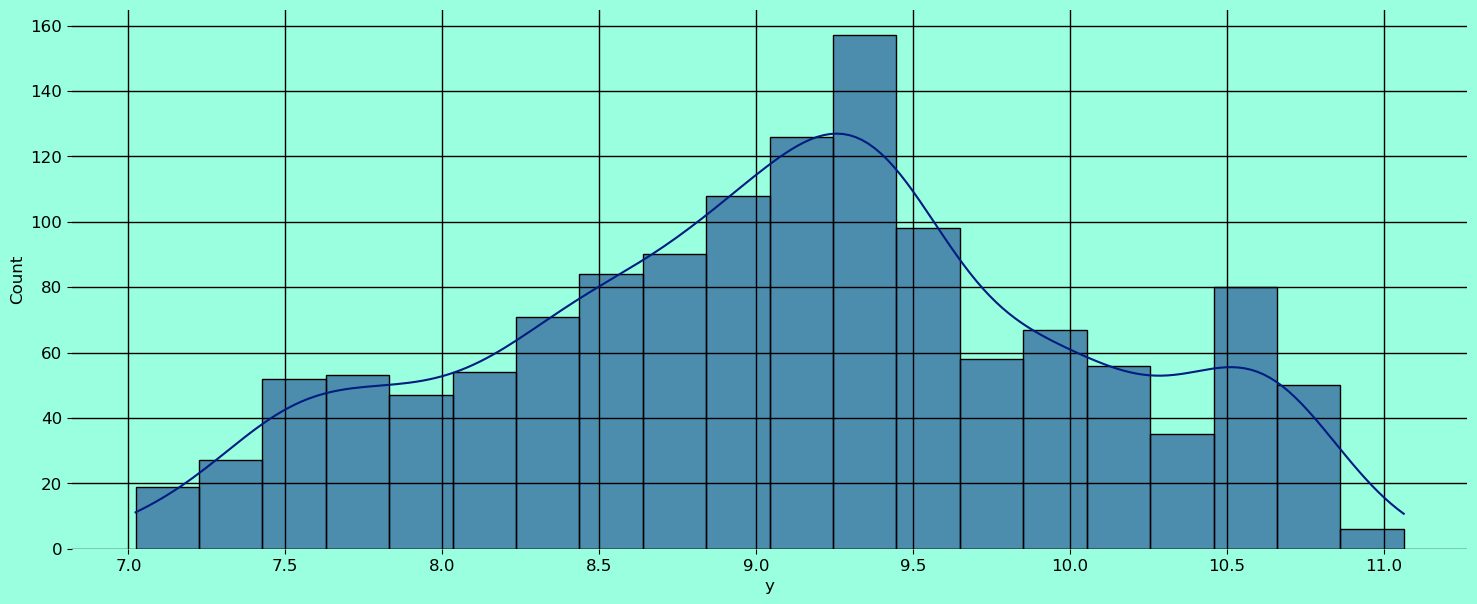

In [64]:
sns.histplot(df_new, x="y", bins = 20, kde = True)
plt.show();

In [65]:
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
from mlforecast import MLForecast

from statsforecast.models import  AutoARIMA, SeasonalNaive

In [66]:
season_length = 7 # Daily data 

# We call the model that we are going to use
models = [AutoARIMA(season_length=season_length),
          SeasonalNaive(season_length=season_length),
          MSTL(
              season_length=[7, 365], # seasonalities of the time series 
              trend_forecaster=AutoARIMA() ) ]# model used to forecast trend 

In [67]:
mlf = MLForecast(models=models,
                 freq='B', 
                 lags=[1 * (i+1) for i in range(12)],
                 lag_transforms={1: [expanding_mean], 12: [(rolling_mean, 7)] }       
                 )

In [69]:
prep = mlf.preprocess(df_new)
prep

,age,sex,bmi,children,smoker,region,y,ds,unique_id,lag1,...,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,expanding_mean_lag1,rolling_mean_lag12_window_size7
18,56,1,40.300,0,0,0,9.268834,2017-01-26,1,7.781210,...,9.313864,7.510345,10.233105,7.908873,10.272397,8.765054,8.893093,9.016827,8.842350,8.727773
19,30,1,35.300,0,1,0,10.514271,2017-01-27,1,9.268834,...,10.586881,9.313864,7.510345,10.233105,7.908873,10.272397,8.765054,8.893093,8.864797,8.607618
20,60,0,36.005,0,0,3,9.490155,2017-01-30,1,10.514271,...,7.516018,10.586881,9.313864,7.510345,10.233105,7.908873,10.272397,8.765054,8.947270,8.795011
21,30,0,32.400,1,0,0,8.330800,2017-01-31,1,9.490155,...,9.287055,7.516018,10.586881,9.313864,7.510345,10.233105,7.908873,10.272397,8.973122,9.062419
22,18,1,34.100,0,0,1,7.036158,2017-02-01,1,8.330800,...,7.781210,9.287055,7.516018,10.586881,9.313864,7.510345,10.233105,7.908873,8.943926,8.763959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,2,9.268661,2022-02-10,1,9.342393,...,10.016626,9.146112,8.860786,9.483670,8.352293,10.689587,9.471269,10.243572,9.101093,8.778362
1334,18,0,31.920,0,0,3,7.698927,2022-02-11,1,9.268661,...,9.242343,10.016626,9.146112,8.860786,9.483670,8.352293,10.689587,9.471269,9.101218,8.798528
1335,18,0,36.850,0,0,1,7.396233,2022-02-14,1,7.698927,...,9.443764,9.242343,10.016626,9.146112,8.860786,9.483670,8.352293,10.689587,9.100168,9.260348
1336,21,0,25.800,0,0,0,7.604867,2022-02-15,1,7.396233,...,9.286925,9.443764,9.242343,10.016626,9.146112,8.860786,9.483670,8.352293,9.098893,9.445082


In [70]:
prep.drop(columns=['unique_id', 'ds']).corr()['y']

age                                0.526186
sex                                0.013114
bmi                                0.132172
children                           0.164597
smoker                             0.666554
region                             0.042934
y                                  1.000000
lag1                               0.011367
lag2                              -0.000214
lag3                              -0.002741
lag4                              -0.031730
lag5                              -0.007563
lag6                               0.025495
lag7                              -0.041390
lag8                               0.009509
lag9                               0.012016
lag10                              0.023854
lag11                             -0.034859
lag12                             -0.033479
expanding_mean_lag1               -0.065736
rolling_mean_lag12_window_size7    0.010436
Name: y, dtype: float64

<a id="8"></a>

<span style="background-color:#673AB7;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #673AB7;padding:0px 20px">Splitting training and test data with exogenous variables</span>

Let's divide our data into sets
1. Data to train our model
2. Data to test our model

For the test data we will use the last 200 daily to test and evaluate the performance of our model.

In [ ]:
prep.columns

In [71]:
prep=prep[['age',  'smoker', 'y', 'ds', 'unique_id', ]]

In [72]:
exogen=prep[['age',  'smoker', 'ds','unique_id', ]]

In [73]:
train_exo = prep[prep.ds<='2021-05-12'] 
test_exo=exogen[(exogen['ds'] > '2021-05-12')]

train_exo.shape, test_exo.shape

((1120, 5), (200, 4))

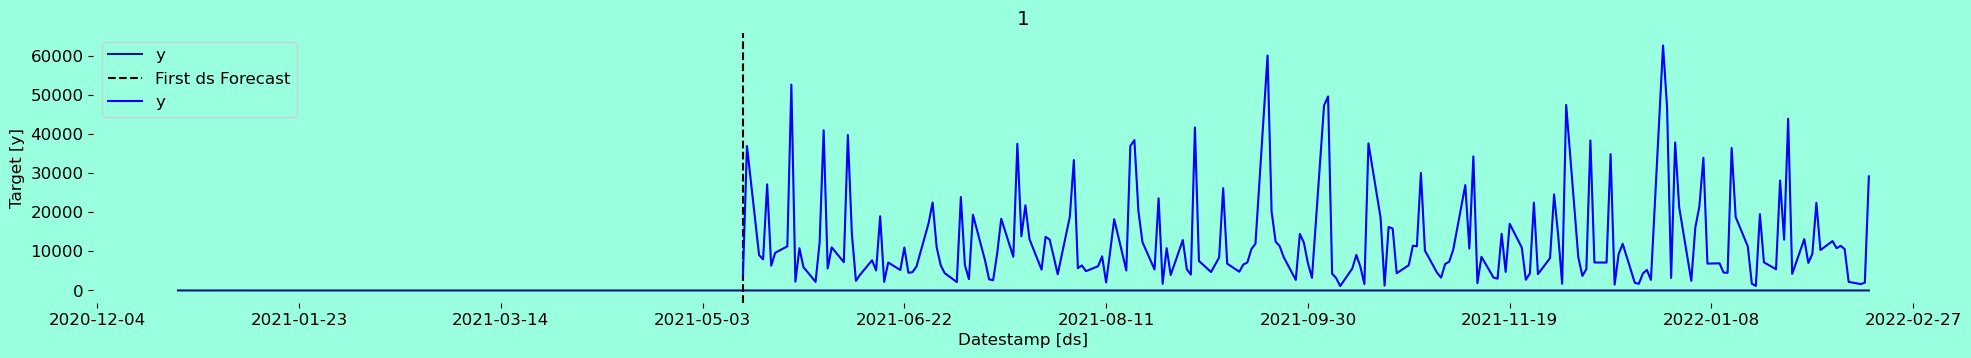

In [78]:
StatsForecast.plot(prep, test, max_insample_length=300)

<a id="9"></a>

<span style="background-color:#673AB7;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #673AB7;padding:0px 20px">Implementation of StatsForecast with exogenous variables</span>

We are going to train the `Arima`,`Holt Winter` model, using the `AutoArima`, `HoltWinters` function. This model will help us forecast egg sales in the next 200 day.

In [79]:
season_length = 7 # Dayly data 
horizon = len(test) # number of predictions

# We call the model that we are going to use
models_exo = [AutoARIMA(season_length=season_length),
          AutoETS(season_length=season_length),
          AutoCES(season_length=season_length),
          AutoTheta(season_length=season_length),
          SeasonalNaive(season_length=season_length),
          SeasonalExponentialSmoothingOptimized(season_length=season_length),
          HoltWinters(season_length=season_length, error_type='A', alias='Hws_add'),
          #HoltWinters(season_length=season_length, error_type='M', alias='Hws_mul'),
          #Holt(season_length=season_length, error_type="A", alias="Holt_Add"),
          #Holt(season_length=season_length, error_type="M", alias="Holt_Multi"),
          MSTL(
              season_length=[7, 365], # seasonalities of the time series 
              trend_forecaster=AutoARIMA() )# model used to forecast trend
          ]

In [80]:
# Instantiate StatsForecast class as sf
sf_exo = StatsForecast(
    models=models_exo,
    freq='B', 
    n_jobs=-1)

<span style="background-color:#673AB7;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #673AB7;padding:0px 20px">Fit the Model</span>

The fit method has two parameters:

* Training data with exogenous variables.
* Data with only exogenous variables.

In [81]:
sf_exo.fit(train_exo, test_exo)

StatsForecast(models=[AutoARIMA,AutoETS,CES,AutoTheta,SeasonalNaive,SeasESOpt,Hws_add,MSTL])

<span style="background-color:#673AB7;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #673AB7;padding:0px 20px">Predict Method</span>

The predict method takes only 2 parameters

* The Horizon: amount of data you want to predict.
* Exogenous variables without the target variable.

We will use the predict method to forecast the last 200 day charge insurance.. This method only has one parameter, the forecast horizon.

In [82]:
Y_hat_exo = sf_exo.predict(horizon, X_df=test_exo)
Y_hat_exo.head()

,ds,AutoARIMA,AutoETS,CES,AutoTheta,SeasonalNaive,SeasESOpt,Hws_add,MSTL
unique_id,,,,,,,,,
1,2021-05-13,-280.535370,39.671497,38.273003,37.796822,27.0,38.559105,38.715069,-243.984879
1,2021-05-14,-157.809311,39.671497,41.170837,40.337730,57.0,42.164528,41.049580,-100.979019
1,2021-05-17,-426.376831,39.671497,41.393803,40.282249,52.0,44.495632,41.477810,-326.812622
1,2021-05-18,-348.336212,39.671497,38.636719,37.669544,28.0,36.214088,38.694805,-276.365173
1,2021-05-19,-443.286102,39.671497,40.943970,40.224552,50.0,39.922558,41.074406,-340.670166


<span style="background-color:#673AB7;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #673AB7;padding:0px 20px">Forecasting Plot</span>

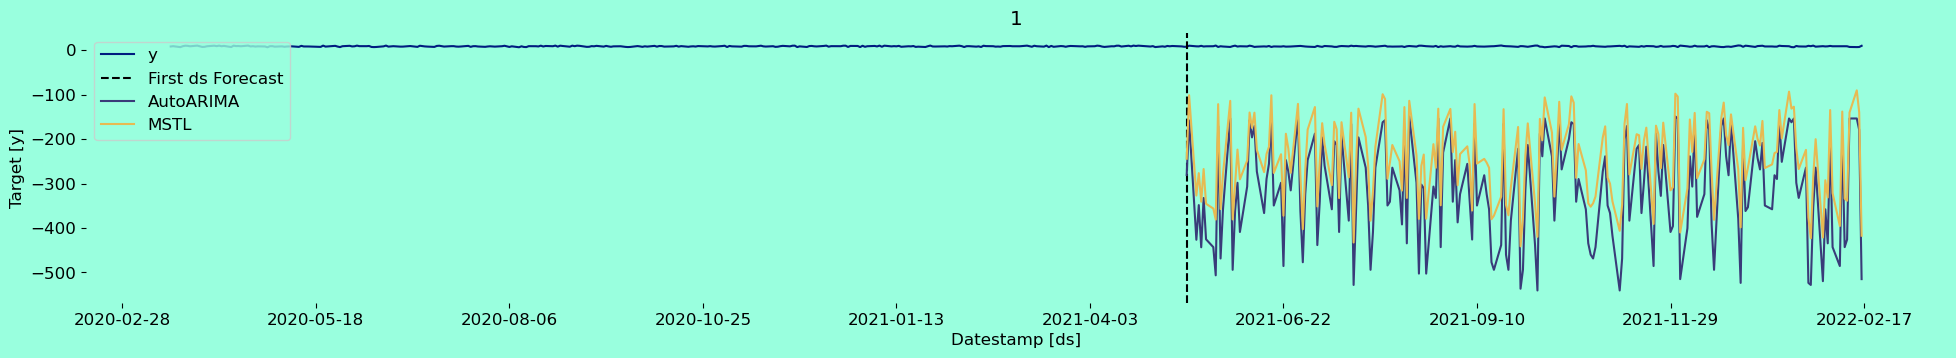

In [83]:
sf.plot(prep, Y_hat_exo, max_insample_length=500, models=["AutoARIMA", "MSTL"])

<a id="10"></a>

<span style="background-color:#673AB7;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #673AB7;padding:0px 20px">Evaluate the model for exogenous variables</span>

In [84]:
from datasetsforecast.losses import (mae, mape, mase, rmse, smape)
from utilsforecast.evaluation import evaluate

In [85]:
actual_exo=prep[prep.ds>'2021-05-12'] 

In [86]:
print("No Exogenous")
print(evaluate_performace(train , test,Y_hat ,models=['AutoARIMA', 'AutoETS', 'CES', 'AutoTheta', 'SeasonalNaive',
       'SeasESOpt', 'Hws_add', 'Hws_mul', 'Holt_Add', 'Holt_Multi', 'MSTL']))
print("====="*13)
print("With Exogenous")
print(evaluate_performace(train_exo , actual_exo,Y_hat_exo ,models=['AutoARIMA', 'AutoETS', 'CES', 'AutoTheta', 'SeasonalNaive',
       'SeasESOpt', 'Hws_add', 'MSTL']))

No Exogenous
                   mase           mae        mape          rmse       smape
AutoARIMA      1.051266  12737.768593   95.552126  17789.446511  185.274139
AutoETS        0.769353   9321.940219  152.798290  12476.880325   72.305231
CES            0.772017   9354.221246  154.226437  12465.054264   72.457330
AutoTheta      0.760225   9211.342296  148.837403  12472.977918   71.795058
SeasonalNaive  0.765182   9271.399624  135.625834  13327.648142   73.739582
SeasESOpt      0.790643   9579.897485  164.932055  12593.520648   72.859361
Hws_add        0.768950   9317.060614  153.097009  12461.970739   72.232144
Hws_mul        0.773467   9371.789531  154.586000  12488.328046   72.575082
Holt_Add       0.786160   9525.580252  160.353269  12488.385957   73.533748
Holt_Multi     0.786152   9525.487522  160.349936  12488.374430   73.533257
MSTL           1.016830  12320.518000  192.528021  15913.464632  100.232662
With Exogenous
                     mase         mae         mape        rm

In [ ]:
Y_hat_exo.columns